## Bayesian Blocks

### Paul Anzel, DATEDATEDATE

If we're trying to histogram our data, we'd like some idea of how many bins we should use. You could just try several and see what looks good, but this is effort intensive and not a particularly coherent way to deal with things.

There are a few standard techniques:
- If you know something about how you're collecting the data (e.g. it's from a detector with finite precision) this could give you some useable bin sizes.
- A bunch of standard approaches, like:
 - __Sturges' Rule__: Number of bins $k = \lceil 1 + \log_2 n \rceil$
 - __Scott's Rule__: For sample standard deviation $s$, use bin width $w = 3.49 s n^{-1/3}$
 - __Freedman-Diaconis__: For interquartile range $IQR$, $w = 2 IQR n^{-1/3}$

However, these tend to oversmooth data, and your binning could probably be finer.

In [1]:
import numpy as np
import numpy.random as rd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [5]:
rd.seed(267)
N = 1000
# A very complicated and disperse dataset
cauchy1 = stats.cauchy(-5, 1.8)
frac_C1 = 0.1
cauchy2 = stats.cauchy(-4, 0.8)
frac_C2 = 0.4
cauchy3 = stats.cauchy(-1, 0.3)
frac_C3 = 0.1
cauchy4 = stats.cauchy(2, 0.8)
frac_C4 = 0.2
cauchy5 = stats.cauchy(4, 1.5)
frac_C5 = 0.2
X_vals = np.concatenate([cauchy1.rvs(np.around(frac_C1*N)),
                         cauchy2.rvs(np.around(frac_C2*N)),
                         cauchy3.rvs(np.around(frac_C3*N)),
                         cauchy4.rvs(np.around(frac_C4*N)),
                         cauchy5.rvs(np.around(frac_C5*N))])
# Cauchy distributions very far out, so truncate 
X_vals = X_vals[(X_vals > -15) & (X_vals < 15)]

X_sample = np.linspace(-15, 15, 300)
sample_dist = (frac_C1*cauchy1.pdf(X_sample) +
               frac_C2*cauchy2.pdf(X_sample) +
               frac_C3*cauchy3.pdf(X_sample) +
               frac_C4*cauchy4.pdf(X_sample) +
               frac_C5*cauchy5.pdf(X_sample))

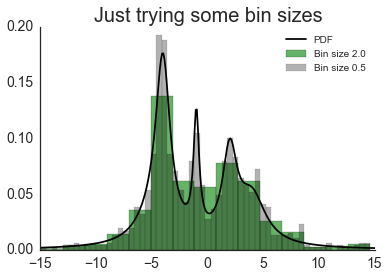

In [7]:
plt.hist(X_vals, bins=15, normed=True, color='g', alpha=0.6, label='Bin size 2.0')
plt.hist(X_vals, bins=60, normed=True, color='k', alpha=0.3, label='Bin size 0.5')
plt.plot(X_sample, sample_dist, color='k', label='PDF')
plt.legend()
plt.title('Just trying some bin sizes', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

In [15]:
sturges_bins = np.ceil(1 + np.log2(N))
print("Number of bins for Sturges' Rule: %d" % sturges_bins)

scotts_bins = np.ceil(float(30)/(3.49*X_vals.std()*N**(float(-1)/3)))
print("Number of bins for Scott's Rule: %d" % scotts_bins)

Number of bins for Sturges' Rule: 11
Number of bins for Scott's Rule: 20


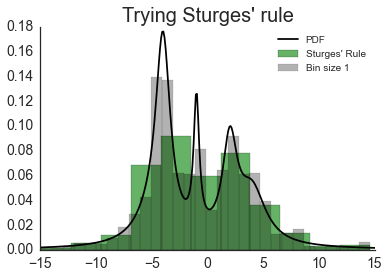

In [20]:
use_sturges = True

if use_sturges:
    plt.hist(X_vals, bins=sturges_bins, normed=True, color='g', alpha=0.6, label="Sturges' Rule")
    plt.title("Trying Sturges' rule", fontsize=20)
else:
    plt.hist(X_vals, bins=scotts_bins, normed=True, color='g', alpha=0.6, label="Scott's Rule")   
    plt.title("Trying Scott's rule", fontsize=20)
plt.hist(X_vals, bins=30, normed=True, color='k', alpha=0.3, label='Bin size 1')
plt.plot(X_sample, sample_dist, color='k', label='PDF')
plt.legend()
plt.tick_params(labelsize=14)
sns.despine()

### Knuth's Rule
#### (Kevin Knuth, not Donald Knuth)

A problem with the above rules is they generally assume some basic form of what your data is supposed to look like (generally, we think it'll be approximately normal). Since our PDF above is definitely non-normal, we run into problems.

Knuth's rule assumes that

### Bayesian Blocks

### Implementation in AstroPy

http://docs.astropy.org/en/latest/visualization/histogram.html

Happily, these routines have already been implemented for us in the AstroPy module (which is a default installation in conda). 

References:
- Knuth's Rule: [Optimal Data-Based Binning for Histograms](http://arxiv.org/pdf/physics/0605197v2.pdf)
- Bayesian Blocks: [Studies in Astronomial Time Series Analysis. VI. Bayesian Block Representations](http://arxiv.org/pdf/1207.5578.pdf)